In [1]:
import pandas as pd
import xarray as xr
import glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
bt = pd.read_csv('CYCLONE_BEST_TRACK_AS_FROM_IMD.csv', index_col = 0)
bt.index = pd.to_datetime(bt.index)
#bt = bt[(bt.index.year == 2019)]

In [3]:
bt_cropped = bt[['Serial Number of system during year', 'Latitude (lat.)', 'Longitude (lon.)', 'Maximum Sustained Surface Wind (kt) ']]

In [4]:
tcs_lmi_centred = []

for tc_id, tc_data in bt_cropped.groupby(bt['Serial Number of system during year']):
    lmi_index = tc_data['Maximum Sustained Surface Wind (kt) '].idxmax()
    tc_data['TimeRelativeToLMI'] = (tc_data.index - lmi_index).total_seconds() / (3600 * 24)
    tcs_lmi_centred += [tc_data]

tcs_lmi_centred = pd.concat(tcs_lmi_centred)

# tcs_lmi_centred = tcs_lmi_centred[['Maximum Sustained Surface Wind (kt) ', 'TimeRelativeToLMI']]

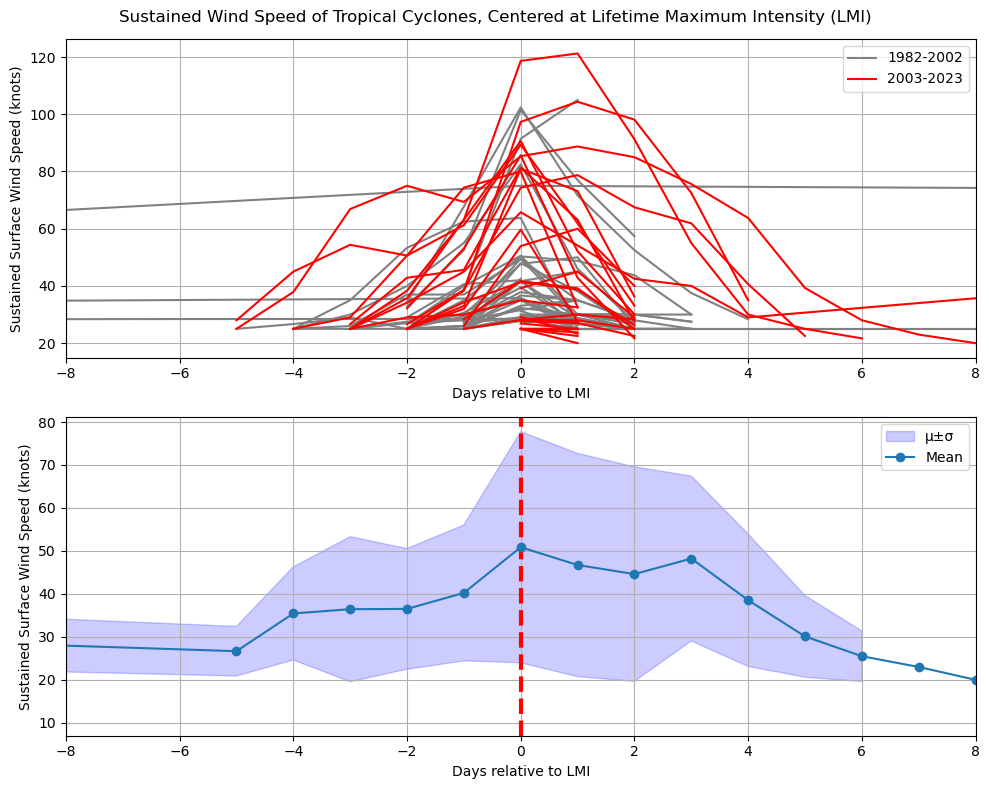

In [5]:
fig, axes = plt.subplots(2,1, figsize = (10,8))
fig.suptitle('Sustained Wind Speed of Tropical Cyclones, Centered at Lifetime Maximum Intensity (LMI)')

axes = axes.flatten()
for tc_id, tc_data in tcs_lmi_centred.groupby(bt['Serial Number of system during year']):
    tc_data = tc_data[['Maximum Sustained Surface Wind (kt) ', 'TimeRelativeToLMI', 'Serial Number of system during year']]
    tc_data.set_index('TimeRelativeToLMI', inplace = True)
    tc_data = tc_data.groupby(tc_data.index.astype(int)).mean()
    if ((tc_id//100) >= 1982) & ((tc_id//100) <= 2012):
        axes[0].plot(tc_data.index, tc_data['Maximum Sustained Surface Wind (kt) '], label = '1982-2002', color = 'gray')
    else:
        axes[0].plot(tc_data.index, tc_data['Maximum Sustained Surface Wind (kt) '], label = '2003-2023', color = 'red')

handles, labels = axes[0].get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
axes[0].legend(unique_labels.values(), unique_labels.keys())

axes[0].set_xlim([-8,8])
axes[0].set_xlabel('Days relative to LMI')
axes[0].set_ylabel('Sustained Surface Wind Speed (knots)')
axes[0].grid(True)

mean = tcs_lmi_centred.groupby('TimeRelativeToLMI').mean()['Maximum Sustained Surface Wind (kt) ']
std = tcs_lmi_centred.groupby('TimeRelativeToLMI').std()['Maximum Sustained Surface Wind (kt) ']

mean = mean.groupby(mean.index.astype(int)).mean()
std = std.groupby(std.index.astype(int)).mean()

axes[1].axvline(0, color = 'red', ls = '--', lw = 3)
axes[1].fill_between(std.index, (mean-std), (mean+std), alpha = 0.2, color = 'blue', label = 'µ±σ')
axes[1].plot(mean.index, mean, marker = 'o', label = 'Mean')
axes[1].legend()
axes[1].set_xlim([-8,8])
axes[1].set_xlabel('Days relative to LMI')
axes[1].set_ylabel('Sustained Surface Wind Speed (knots)')
axes[1].grid(True)
fig.tight_layout()

---

## Sorting out TCs into MHW and NON-MHW ones

In [68]:
ds = xr.open_dataset('./mhw_1982_2023.nc').rename({'__xarray_dataarray_variable__':'mhw_mask'})
ds['time'] = pd.to_datetime([str(x).split('T')[0] for x in ds.time.values])

## Selecting only the cyclones which had atleast 2 days worth of data before reaching LMI point

In [69]:
df = pd.DataFrame(columns = ['TC_ID', 'HOURS_BEFORE_LMI_GREATER_THAN_2DAYS'])
for tc_id, tc_data in tcs_lmi_centred.groupby(tcs_lmi_centred['Serial Number of system during year']):
    tvals = tc_data[tc_data.TimeRelativeToLMI <= 0].index
    if (tvals[-1] - tvals[0]).total_seconds()/3600 >= 48: 
        # Difference between when first and last entry (LMI) is recorded should be >= 48 hrs
        tdelta = 1
    else:
        tdelta = 0
    df.loc[len(df)] = [tc_id, tdelta]

tcs_lmi_centred_selected = tcs_lmi_centred[tcs_lmi_centred['Serial Number of system during year'].isin(df[df['HOURS_BEFORE_LMI_GREATER_THAN_2DAYS'] == 1]['TC_ID'].values)]

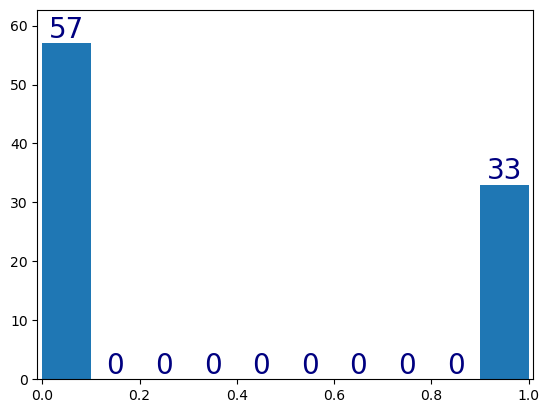

In [70]:
values, bins, bars = plt.hist(df['HOURS_BEFORE_LMI_GREATER_THAN_2DAYS'])
plt.bar_label(bars, fontsize=20, color='navy')
plt.margins(x=0.01, y=0.1)
plt.show()

In [71]:
tcs_lmi_centred_selected

,Serial Number of system during year,Latitude (lat.),Longitude (lon.),Maximum Sustained Surface Wind (kt),TimeRelativeToLMI
DATETIME,,,,,
1982-11-04 12:00:00,198215,11.5,66.0,25.0,-4.000
1982-11-05 00:00:00,198215,11.7,65.7,30.0,-3.500
1982-11-05 03:00:00,198215,12.5,65.0,35.0,-3.375
1982-11-05 12:00:00,198215,13.0,65.0,40.0,-3.000
1982-11-06 00:00:00,198215,13.5,65.3,45.0,-2.500
...,...,...,...,...,...
2023-10-24 00:00:00,202306,15.9,52.1,60.0,1.875
2023-10-24 03:00:00,202306,16.0,51.8,50.0,2.000
2023-10-24 06:00:00,202306,16.1,51.5,40.0,2.125


## Checking the percentage of points that pass over an MHW (using 'nearest' gricell method to determine)

In [72]:
df = pd.DataFrame(columns = ['TC_ID', 'PERCENT_POINTS_OVER_MHW'])
for tc_id, tc_data in tcs_lmi_centred_selected.groupby(tcs_lmi_centred_selected['Serial Number of system during year']):
    mhw_mask_vals = []
    for x in tc_data.iterrows():
        mhw_mask_vals = mhw_mask_vals + [ds.sel(lat = x[1]['Latitude (lat.)'], lon = x[1]['Longitude (lon.)'], time = x[0], method = 'nearest')['mhw_mask'].item()]

    mhw_mask_vals = np.array(mhw_mask_vals)
    mhw_mask_vals[np.isnan(mhw_mask_vals)] = 0
    thres = (mhw_mask_vals.sum()*100)/mhw_mask_vals.shape[0]
    df.loc[len(df)] = [tc_id, np.round(thres,2)]

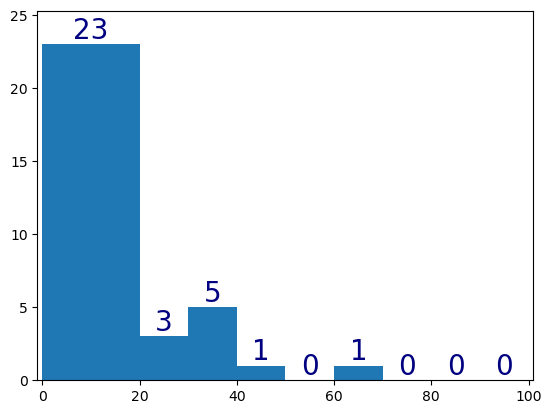

In [73]:
values, bins, bars = plt.hist(df['PERCENT_POINTS_OVER_MHW'], bins = [0,20,30,40,50,60,70,80,90,100])
plt.bar_label(bars, fontsize=20, color='navy')
plt.margins(x=0.01, y=0.1)
plt.show()

## Classifying MHW and non-MHW TCs based on the study being referred to 

To examine the impact of an MHW on a TC in the intensification phase, we defined an MHW TC as a TC whose center stayed within 1 degree of an MHW area for two days or more before reaching the LMI. <br>
TCs that never encountered MHWs in their lifetime were defined as non-MHW TCs. This spatial threshold (1 degree of an MHW area) can cover the TC core area, so it can directly impact TC and the <br>
time threshold (more than 2 days) is enough time for impact on the TCs15,16. Additionally, TCs that encountered an MHW region <24 hours before reaching the LMI or TCs that passed an MHW region <br>
after the LMI were excluded from this study.

In [86]:
# Function to calculate the distance in degrees
def distance_in_degrees(lat1, lon1, lat2, lon2):
    delta_lat = lat2 - lat1
    delta_lon = lon2 - lon1
    # Adjust for the varying distance of longitude with latitude
    distance = np.sqrt(delta_lat**2 + (delta_lon * np.cos(np.radians(lat1)))**2)
    return distance

def check_if_point_close_to_mhw(x):
    mask = ds.sel(time = '{}-{:02d}-{}'.format(x[0].year, x[0].month, x[0].day))['mhw_mask'].values 

    # Given point (lat, lon)
    point_lon, point_lat = x[1]['Longitude (lon.)'], x[1]['Latitude (lat.)']

    # Loop through all grid points and check if within 1-degree radius
    found_1_within_radius = False
    for lat_idx, lat in enumerate(ds['lat'].values):
        for lon_idx, lon in enumerate(ds['lon'].values):
            distance = distance_in_degrees(point_lat, point_lon, lat, lon)
            if distance <= 0.25:  # Check within 1-degree radius
                if mask[lat_idx, lon_idx] == 1:
                    found_1_within_radius = True
                    break
        if found_1_within_radius:
            break

    if found_1_within_radius:
        return 1
    else:
        return 0 

In [102]:
df = pd.DataFrame(columns = ['TC_ID', 'CLASS'])
for tc_id, tc_data in tcs_lmi_centred_selected[tcs_lmi_centred_selected.index.year<2023].groupby(tcs_lmi_centred_selected[tcs_lmi_centred_selected.index.year<2023]['Serial Number of system during year']):
    mhw_flag = []
    for x in tc_data.iterrows():
        mhw_flag = mhw_flag + [check_if_point_close_to_mhw(x)]
    tc_data['MHW_FLAG'] = mhw_flag
    if tc_data[tc_data.TimeRelativeToLMI < 0]['MHW_FLAG'].sum() >= 8:
        # Condition for MHW TC: Atleast the last 1 days' entries (1 day = 8 entries)
        # before LMI point is reached are close to any MHW-identified gridcells
        df.loc[len(df)] = [tc_id, 'MHW']
    elif tc_data['MHW_FLAG'].sum() == 0:
        # Condition for NON-MHW TC: At no point is a TC's best track is 
        # close to a MHW-identified gridcell
        df.loc[len(df)] = [tc_id, 'NON-MHW']
    else:
        # Other TCs that come close to an MHW atleast once, but are not 
        # thoroughly (atleast by the definition we chose) impacted by 
        # the MHW (like MHW TCs).
        df.loc[len(df)] = [tc_id, 'OTHER']

([<matplotlib.patches.Wedge at 0x31e8b42d0>,
 [Text(0.166570601230037, 1.0873151497178102, 'NON-MHW'),
  Text(-0.902839855549928, -0.6283949357136684, 'OTHER'),
  Text(0.7578634809547325, -0.7972721895533394, 'MHW')],
 [Text(0.09085669158002017, 0.5930809907551692, '45.2%\n(14)'),
  Text(-0.49245810302723336, -0.34276087402563726, '29.0%\n(9)'),
  Text(0.41338008052076314, -0.4348757397563669, '25.8%\n(8)')])

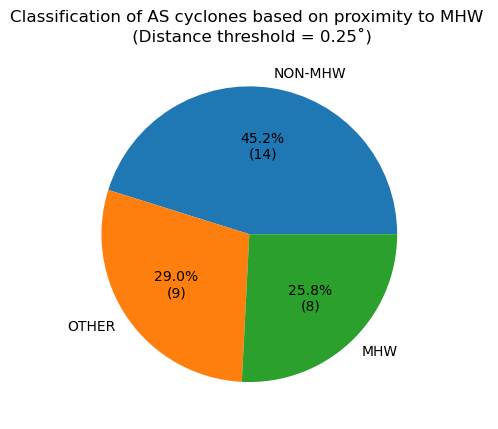

In [103]:
#https://stackoverflow.com/a/71515035/2901002
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

s = df['CLASS'].value_counts()
plt.title('Classification of AS cyclones based on proximity to MHW \n (Distance threshold = 0.25˚)')
plt.pie(s,labels = s.index, autopct=autopct_format(s))

In [104]:
tcs_classified = {'MHW':[], 'NON-MHW':[], 'OTHER':[]}

for idx in df['TC_ID'][df['CLASS'] == 'MHW'].values:
    tcs_lmi_centred_selected[tcs_lmi_centred_selected['Serial Number of system during year'] == idx]
    tcs_classified['MHW'] += [tcs_lmi_centred_selected[tcs_lmi_centred_selected['Serial Number of system during year'] == idx]]

for idx in df['TC_ID'][df['CLASS'] == 'NON-MHW'].values:
    tcs_lmi_centred_selected[tcs_lmi_centred_selected['Serial Number of system during year'] == idx]
    tcs_classified['NON-MHW'] += [tcs_lmi_centred_selected[tcs_lmi_centred_selected['Serial Number of system during year'] == idx]]

for idx in df['TC_ID'][df['CLASS'] == 'OTHER'].values:
    tcs_lmi_centred_selected[tcs_lmi_centred_selected['Serial Number of system during year'] == idx]
    tcs_classified['OTHER'] += [tcs_lmi_centred_selected[tcs_lmi_centred_selected['Serial Number of system during year'] == idx]]

In [105]:
tcs_classified['MHW'] = pd.concat(tcs_classified['MHW'])
tcs_classified['NON-MHW'] = pd.concat(tcs_classified['NON-MHW'])
tcs_classified['OTHER'] = pd.concat(tcs_classified['OTHER'])

In [106]:

def ensemble_plotter(tc_data = None, ax = None, c = None, tc_type = None):
    mean = tc_data.groupby('TimeRelativeToLMI').mean()['Maximum Sustained Surface Wind (kt) ']
    std = tc_data.groupby('TimeRelativeToLMI').std()['Maximum Sustained Surface Wind (kt) ']

    # mean = mean.groupby(mean.index.astype(int)).mean()
    # std = std.groupby(std.index.astype(int)).mean()
    
    ax.fill_between(std.index, (mean-std), (mean+std), alpha = 0.2, color = c, label = tc_type+': µ±σ')
    ax.plot(mean.index, mean, marker = 'o', label = tc_type+': Mean', color = c)

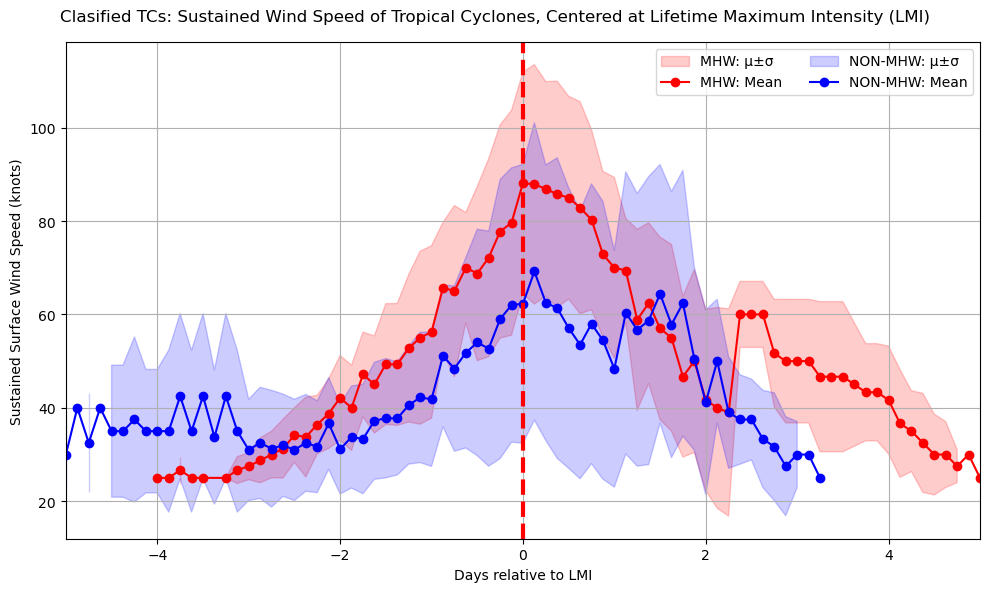

In [107]:
fig, ax = plt.subplots(1,1, figsize = (10,6))
fig.suptitle('Clasified TCs: Sustained Wind Speed of Tropical Cyclones, Centered at Lifetime Maximum Intensity (LMI)')
ensemble_plotter(tcs_classified['MHW'], ax, 'red', tc_type = 'MHW')
ensemble_plotter(tcs_classified['NON-MHW'], ax, 'blue', tc_type = 'NON-MHW')
#ensemble_plotter(tcs_classified['OTHER'], ax, 'green', tc_type = 'NON-MHW')
ax.axvline(0, color = 'red', ls = '--', lw = 3)
ax.legend(ncols = 2)
ax.set_xlim([-5,5])
ax.set_xlabel('Days relative to LMI')
ax.set_ylabel('Sustained Surface Wind Speed (knots)')
ax.grid(True)
fig.tight_layout()